In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
import torchaudio
import torch
import librosa

from Const import *
from helper_code import *
from audio_util import AudioUtil
from extract_features import *

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 25, 15

In [3]:
data_folder = "C:/Users/lumin/Desktop/Work/20212/Data/circor-heart-sound/final/test"
example_file = '50149_MV.wav'

found_file = False
patient_files = find_patient_files(data_folder)

for patient in patient_files:
    current_patient_data = load_patient_data(patient)
    current_recordings_paths, current_recordings = load_recordings(data_folder, current_patient_data, get_paths=True, preprocess=True)
    
    break


In [6]:
cur_recording_path = current_recordings_paths[0]
cur_recording = current_recordings[0]

In [7]:
dem_features = get_clinical_features(current_patient_data)

In [8]:
print(dem_features)

[72.   0.   1.  98.  15.9  0. ]


In [10]:
T = round(len(cur_recording) / NEW_SAMPLING_RATE)
t = np.linspace(0, T, len(cur_recording), endpoint=False)

In [62]:
from torch.nn import ZeroPad2d

In [58]:
from tqdm.notebook import tqdm

In [77]:
recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

recording_cycles_embeddings = None

for patient in tqdm.range(patient_files):
    current_patient_data = load_patient_data(patient)
    current_recordings_paths, current_recordings = load_recordings(data_folder, current_patient_data, get_paths=True, preprocess=True)

    cur_recording_cycles_embeddings = torch.zeros((len(recording_locations), 128 * EMBEDDING_ROWS))

    for i in range(len(current_recordings_paths)):
        segmentation_file_path = AudioUtil.get_segmentation_file(current_recordings_paths[i])
        cardiac_states = AudioUtil.get_cardiac_states(segmentation_file_path)

        if cardiac_states is None:
            continue

        cardiac_cycles = AudioUtil.split_cardiac_cycles(current_recordings[i], cardiac_states)
        
        loc_embeddings = None

        for cycle in tqdm(cardiac_cycles):
            cur_cycle = AudioUtil.audio_norm(cycle)
            cur_cycle = AudioUtil.pad_signal(cur_cycle, MAX_DURATION)

            example = vggish_input.waveform_to_examples(data=cur_cycle, sample_rate=NEW_SAMPLING_RATE)
            embeddings = embedding_model.forward(example)
            
            if loc_embeddings is None:
                loc_embeddings = embeddings
            else:
                loc_embeddings = torch.vstack((loc_embeddings, embeddings))

        # Pad embeddings to reach size of (EMBEDDING_ROWS, 128)
        cur_no_rows = loc_embeddings.size()[0]
        pad = ZeroPad2d((0, 0, 0, EMBEDDING_ROWS - cur_no_rows))
        loc_embeddings = pad(loc_embeddings)

        cur_recording_cycles_embeddings[i] = torch.flatten(loc_embeddings)

    cur_recording_cycles_embeddings = torch.flatten(cur_recording_cycles_embeddings)
    recording_cycles_embeddings = cur_recording_cycles_embeddings if recording_cycles_embeddings is None else torch.vstack((recording_cycles_embeddings, cur_recording_cycles_embeddings))

KeyboardInterrupt: 

In [76]:
cur_recording_cycles_embeddings.size()

torch.Size([178560])

In [55]:
recording_embeddings.size()

torch.Size([42, 128])

In [43]:
cycle = AudioUtil.audio_norm(cardiac_cycles[0])
cycle = AudioUtil.pad_signal(cycle, MAX_DURATION)

In [44]:
print(cycle.shape)

(3000,)


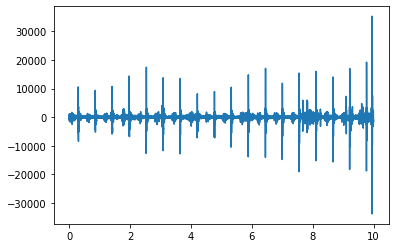

In [14]:
fig, ax = plt.subplots()
ax.plot(t, cur_recording)

In [8]:
from torchvggish import vggish, vggish_input

# Initialise model and download weights
embedding_model = vggish()
# embedding_model.eval()

In [47]:
example = vggish_input.waveform_to_examples(data=cycle, sample_rate=NEW_SAMPLING_RATE)
embeddings = embedding_model.forward(example)

In [46]:
print(embeddings.size())

torch.Size([3, 128])


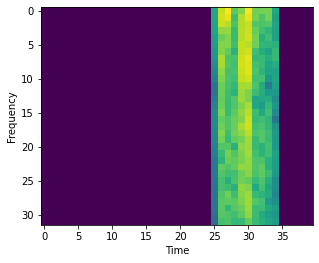

In [15]:
dur_aud = AudioUtil.pad_signal(cardiac_cycles[1], MAX_DURATION)

spec = AudioUtil.spectro_gram(dur_aud)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.imshow(spec)

In [1]:
from torchvggish import vggish, vggish_input

# Initialise model and download weights
embedding_model = vggish()

In [16]:
spec

tensor([[13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405],
        [13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405],
        [13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405],
        ...,
        [13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405],
        [13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405],
        [13.9405, 13.9405, 13.9405,  ..., 13.9405, 13.9405, 13.9405]])

In [19]:
example = vggish_input.waveform_to_examples(data=spec, sample_rate=NEW_SAMPLING_RATE)
embeddings = embedding_model.forward(example)

TypeError: mean() received an invalid combination of arguments - got (axis=int, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [1]:
import pickle

In [3]:
with open("./models/embeddings_178k.pickle", "rb") as fp:
    data = pickle.load(fp)
    print(data['cycles_embeddings'].size())

{'cycles_embeddings': tensor([175.,   8., 147.,  ...,   0.,   0.,   0.], requires_grad=True)}
